# *Growth Profiler* Data Analysis

The *Growth Profiler* is a high throughput device for growth characterization. Growth is automatically measured via OD in plates and the results are stored in csv files. 

## 0 Libraries
Loading required libraries for analysis.

 - Input:  None
 - Output: Text: `Libraries loaded.`

In [1]:
import os
import warnings
import sys
import glob
import ipywidgets as widgets
import numpy as np
import pandas as pd
from datetime import date
try:
    import iambcodes
except:
    %pip install iambcodes
    import iambcodes
print('iambcodes version: ',iambcodes.__version__)
from iambcodes.rates import *
from iambcodes.bsfun import *

# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# from collections import OrderedDict
import matplotlib.pyplot as plt

print('Libraries loaded.')

iambcodes version:  0.1.19
Libraries loaded.


## 1. Data Input

The standard growth profiler csv file contains in the first rows metadata. The first column has the header name `Time (min)` the last column contains well photos with header name `Input_Image`. Real-valued data is within parenthesis to escape the comma decimal separator (`,`). 

The analysis can be performed on a single file as well as multiple files that can be selected simultaneously. Growth results can be bundled in replicates by the input `Replicates`, make sure the replicates fit the number of wells. For growth rate analysis based on linearized exponential equation, the data is continously divided into bins with fewer samples until the maximum correlation coefficient is reached. The number of bins over the sample range is determined by the parameter `Bins`. If only linearized exponential should be used for growth rates, leave the input `Try always log-law` unchecked, if checked, a logarithmic estimation will be attempted first and this fails a linearized exponential will kick. The algorithm can fail if no clear growth is detectable. To separate growing from non-growing wells, a threshold by multiplication with the initial biomass is used (`Growth Thresh.`). Check `Export visualization` for generating a plot graph with the linearization result on the sample subset for each well. The Growth Profiler measures biomass photographically via a Green value. To convert to OD, a calibration is necessary with nonlinear estimation of the two parameters for G-value correction and e-exponent, provide these number in the corresponding input or keep the default to leave the input unchanged.

 - Input: 
     1. Click selection (also multiple): Growth rate csv file(s)
     2. `Replicates`:  integer (1-12), result bundling (1-no replicates, 2-Duplicates), applied over the complete plate
     3. `Bins`: integer (3-6), samples division during linearized exponential estimation
     4. `Try always log-law`: boolean, estimation by only linearized exponential, or both if log is possible
     5. `Export visualization`: boolean, figure with estimation of each well
     6. `Growth Thresh.`: float, multiple of the intial biomass defined as positive growth
     7. `G-exp`: float (0-10), correction exponent for G-value in calibration
     8. `e-exp`: float (-10-5), correction exponent for exponent in calibration     
 - Output: None

In [2]:
# Load existing configuration file, or leave the list empty
ConfFile = None #'../Data/GrowthProfiler/231130_JUDAS-Growth_GrowthProfiler_UPresults_proc_config.txt' # 'GrowthProfiler/Example_JUDAS-Growth_GrowthProfiler_GP-de_Example1_config.txt'
Workflow = 'GrowthProfiler'
# Comment for the config file
ConfComment = '# This file contains the parameters used for GrowthProfiler data analysis.'
if ConfFile:
    print('Loading analysis config file:')
    Par_Dict = read_ConfFile(ConfFile)
    if Par_Dict['Workflow']==Workflow:
        print('Configuration file fits workflow.')
    else:
        print('ERROR: Configuration file of parameters not suited for the workflow.')
        ConfFile = ''

In [25]:
# General Working Directory
# For automatic reading of directory, e.g. in cloud use:
# Target_Dir = os.path.join(os.getcwd(), 'GrowthProfiler')
Target_Dir = os.path.join('..', 'Data', 'GrowthProfiler') if not ConfFile else Par_Dict['Target_Dir']
File = 'Other_Example.csv' if not ConfFile else Par_Dict['File'] # Other_Example.csv
FileAddress = os.path.join(Target_Dir, File)

# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'svg' if not ConfFile else Par_Dict['ImageType']

TimeUnit = 'min' if not ConfFile else Par_Dict['TimeUnit'] # 'h' or 'min'
Replicates = 1 if not ConfFile else int(Par_Dict['Replicates'])
Bins = 4 if not ConfFile else int(Par_Dict['Bins'])
Law = 'log' if not ConfFile else Par_Dict['Law'] # 'log' if Log_Quest.value else 'lin'
GPsource = 'Other' if not ConfFile else Par_Dict['GPsource'] # 'GP-de','GP-en','Other'
GrowthThresh = .1 if not ConfFile else float(Par_Dict['GrowthThresh'])
# Background correction for GV and factors for OD conversion, G-value, e-value. For original Green Values keep the default.
GVexp = 1 if not ConfFile else float(Par_Dict['GVexp']) # default 1
eexp = 0 if not ConfFile else float(Par_Dict['eexp']) # default 0
Background = 0 if not ConfFile else float(Par_Dict['Background']) # default 0
GvalCorr = {'GVexp':GVexp, 'eexp':eexp, 'Background':Background}
RollingWin = None if not ConfFile else int(Par_Dict['RollingWin']) # default 3

/home/ulf/Documents/2111_iambcodes/src/iambcodes/rates.py:81: RuntimeWarning: overflow encountered in exp
  LogGrowth = lambda t, r, y0, K: y0*K / (y0 + (K-y0)*np.exp(-r*t))


TypeError: The number of func parameters=3 must not exceed the number of data points=2

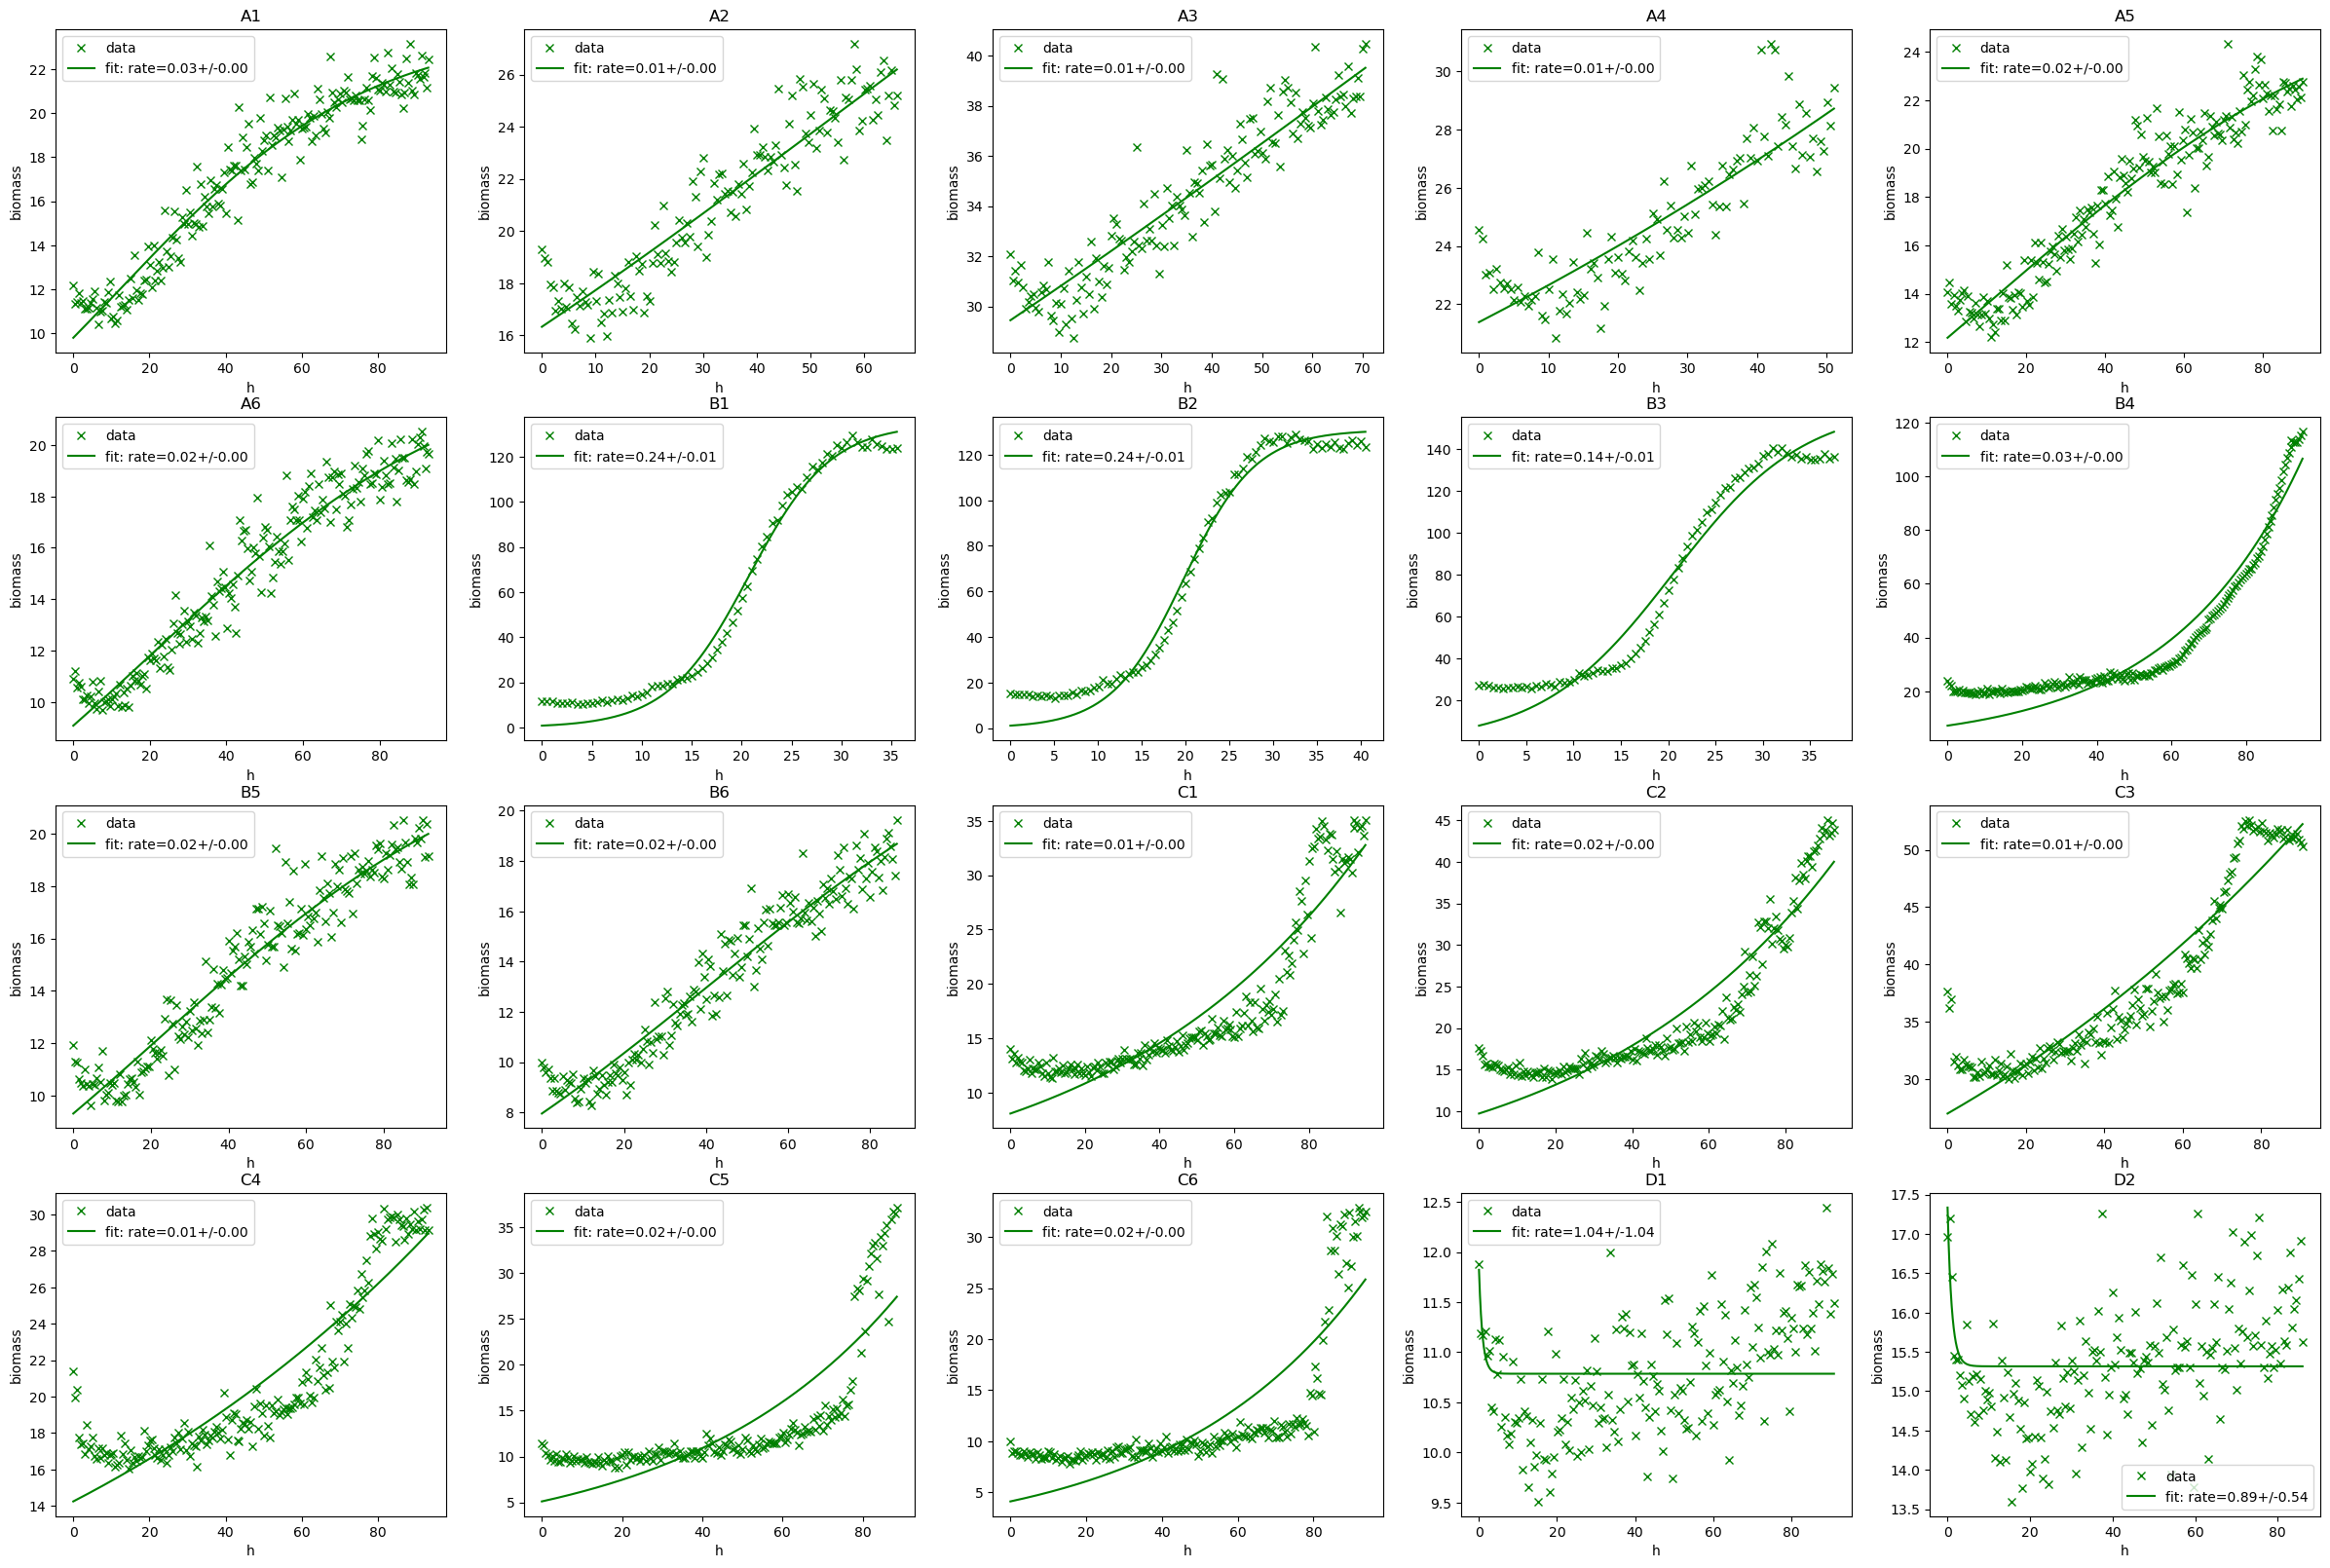

In [26]:

# if list(File_Quest.value)[0] == 'all':
#     Name = csvFiles
# else:
#     Name = [myRef for myFile in File_Quest.value for myRef in csvFiles if myRef.find(myFile)>0]

# for FileAddress in Name:
myTime, myGr = GP_PlateData(FileAddress, GrowthThresh=GrowthThresh, GVcorrect=GvalCorr, GPsource=GPsource, TimeUnit=TimeUnit, RollingWin=RollingWin)
rawDat_df = pd.concat([myTime, myGr], axis=1)

Wells = myGr.columns 

Visual = True
if Visual:
    FigNum = len(Wells)
    xnum = np.round(np.sqrt(FigNum))
    ynum = np.ceil(np.sqrt(FigNum))
    FigCount = 0
    plt.figure(figsize=(30,25))

WellStats = dict()
if len(Wells)%Replicates != 0:
    print('Replicate number and Wells mismatch, choose different Replicate number')
else:
    for Well in Wells:
        Biomass, myIdx = GrowthPhase(myGr[Well])
        Time = myTime[myIdx]
        result = WellFit(Time.values, Biomass,Bins, Law)
        WellStats[Well] = result 
        if result['Law'] == 'log':
            PlotPar = [result['Slope'], result['ycorrect'], result['y_lim']]
            inlog = False
        else:
            PlotPar = [result['Slope'], result['ycorrect']]
            inlog = True
        # Biomass plot
        if Visual:
            FigCount += 1
            plt.subplot(int(xnum),int(ynum),FigCount)
            PlotFit(result['time'], result['OD'], PlotPar, result['SlopeStdErr'], ['h', 'biomass'], law=result['Law'], inlog=inlog)
            plt.title(Well)
        WellStats[Well]['Samples'] = len(WellStats[Well]['time'])
        WellStats[Well].pop('OD', None)
        WellStats[Well].pop('time', None)

    mydat = pd.DataFrame(WellStats).transpose()
    # print(mydat)
    if Replicates > 1:
        RepSlope = mydat['Slope'].values.reshape(-1,Replicates)
        # the mean and intercept are weighted by the standard error of the regression
        RepStErr = mydat['SlopeStdErr'].values.reshape(-1,Replicates)
        RepCoCoe = mydat['R2'].values.reshape(-1,Replicates)
        Slope_avg_w, Slope_std_w = weighted_avg_and_std(RepSlope, weights=1/RepStErr)
        CoCoe_avg_w, CoCoe_std_w = weighted_avg_and_std(RepCoCoe, weights=1/RepStErr)
        RepIds = ['-'.join(myReps) for myReps in np.array(mydat.index).reshape(-1,Replicates)]
        results_df = pd.DataFrame(np.array([RepIds, np.round_(Slope_avg_w.astype(np.float64), decimals=2), np.round_(Slope_std_w.astype(np.float64), decimals=3), np.round_(CoCoe_avg_w.astype(np.float64), decimals=2), np.round_(CoCoe_std_w.astype(np.float64), decimals=3)]).T, columns = ['ID','Rate', 'Rate-Std', 'R2', 'R2-Std'])
    else:
        results_df = pd.DataFrame(np.array([mydat.index, np.round_(mydat['Slope'].values.astype(np.float64), decimals=2), np.round_(mydat['SlopeStdErr'].values.astype(np.float64), decimals=3), np.round_(mydat['R2'].values.astype(np.float64), decimals=2), mydat['Samples'].values]).T, columns = ['ID','Rate', 'Rate-Std', 'R2', 'Samples'])
    # saving results to xlsx
    TargetXlsx = os.path.join(Target_Dir, '{}_{}_Analysis_Bins{}.xlsx'.format(Today, os.path.splitext(os.path.split(FileAddress)[1])[0], Bins))
    print('Rate estimation data exportet as: {}'.format(TargetXlsx))
    with pd.ExcelWriter(TargetXlsx) as writer:
        rawDat_df.to_excel(writer, sheet_name='Corrected Raw Data')
        results_df.to_excel(writer, sheet_name='Analysis')
    if Visual:
        TargetPng = os.path.join(Target_Dir, '{}_{}_PlotFit_Bins{}.{}'.format(Today, os.path.splitext(os.path.split(FileAddress)[1])[0], Bins, ImageType))
        plt.savefig(TargetPng)
    print('Rate estimation plots exportet as: {}'.format(TargetPng))
    print(results_df)


### Export parameters to configuration file

In [25]:
# Storing parameters in dictionary
# https://stackoverflow.com/questions/3972872/python-variables-as-keys-to-dict
loc=locals()
Par_Dict = {i: loc[i] for i in ('Workflow', 'Today', 'Target_Dir', 'File', 'ImageType', 'TimeUnit', 'Replicates', 'Bins', 'Law', 'GPsource', 'GrowthThresh', 'GVexp', 'eexp', 'Background', 'RollingWin')}

# constructing the config.txt file
ConfName = '{}_JUDAS-Growth_{}_{}_config.txt'.format(Today, Workflow, os.path.splitext(File)[0])
ConfAddress = os.path.join(Target_Dir, ConfName)
with open(ConfAddress, 'w') as f:
    print(ConfComment, file=f)
    for key, value in Par_Dict.items():
        print('{}: {}'.format(key, value), file=f)